In [1]:
import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image, ImageDraw
import pandas as pd
import scipy.special as sp
import scipy.linalg as sl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewnorm
from itertools import islice
import time
import copy
vec1 = pd.read_csv('demog_vectors.csv')
%pip install -upgrade ipywidgets
clear_output()
#update

Updated Version

	Family split when the family size > x
	How can family try to find new lands? 
	They can take empty lands -> but that’s the rules? -> Distance and capacity first
	When a family is small but got a land that is too large for them, e.g., 3x -> swap with the large family that has less times than theirs.


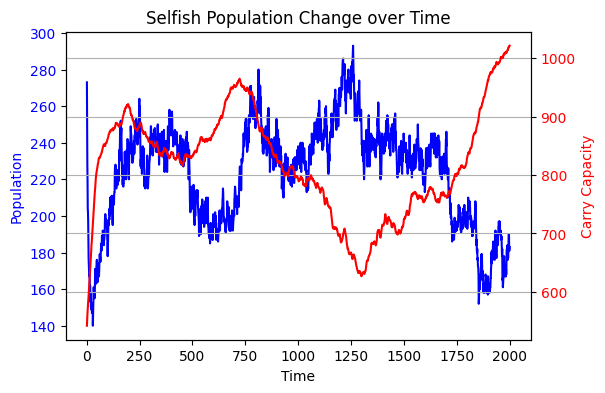

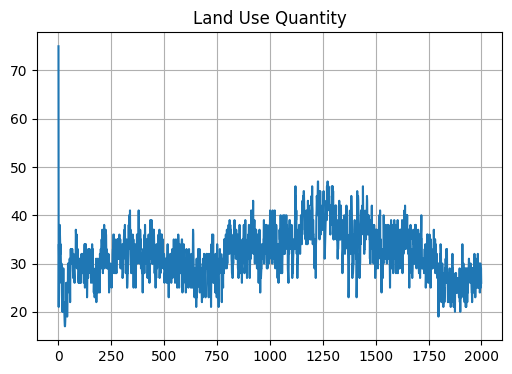

In [3]:
def communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, inital_capacity, split, migration):
    def family_num(max_size_family, num_household): # Piosson distribution (the mean is lambda)
        nums = np.random.poisson((max_size_family/2), num_household)
        nums = np.clip(nums, 1, max_size_family)
        return nums
    
    if inital_capacity == 'different':
        def carry_capacity(K_star_t, initial_lands):  
            nums = np.random.poisson((K_star_t/4), initial_lands)
            nums = np.clip(nums, 1, K_star_t)
            return nums
    if inital_capacity == 'unify':
        def carry_capacity(K_star_t, initial_lands):
            nums = np.full(initial_lands, K_star_t)
            return nums

    def calculate_effectiveness_and_consumption(population_vector, vec1):
        phi = vec1.phi  # Worker effectiveness parameter
        rho = vec1.rho  # Consumption parameter    
        max_lands = np.sum(population_vector * phi) 
        consumption = np.sum(population_vector * rho)
        return round(max_lands), consumption

    np.random.seed(42)
    def generate_left_skewed_weights(num_elements):
        a = 0  # skewness
        loc = 70  # location
        scale = 60  # scale
        z = (np.arange(num_elements) - loc) / scale
        pdf = 2 * stats.norm.pdf(z) * stats.norm.cdf(a * z)
        return pdf
    initial_fam_sizes = family_num(max_size_family, num_household) 

    num_p0_rows = vec1.shape[0]
    family_demands = {} 
    age_proportions = generate_left_skewed_weights(num_p0_rows)
    age_proportions = np.array(age_proportions) / np.sum(age_proportions)
    if len(age_proportions) < num_p0_rows: # make sure age_proportions matches the number of rows in vec1
        age_proportions = np.append(age_proportions, 0)  # add a zero proportion for the extra age group
    family_demands = {}
    family_demands[0] = {}
    for idx, size in enumerate(initial_fam_sizes):  ###### change 
        population_vector = np.random.multinomial(size, age_proportions)       
        max_lands, consumption = calculate_effectiveness_and_consumption(population_vector, vec1)
        family_demands[0][idx] = {'family_number': idx, 'family_matrix': population_vector, 'demands': consumption, 'land_number': None} 

    def update_population_vector(population_vector, vec1, z):
        p0 = vec1.pstar * sp.gdtr(1.0 / vec1.mortscale[0], vec1.mortparms, z) #sometimes p0[i] is None??
        m0 = vec1.mstar * sp.gdtr(1.0 / vec1.fertscale[0], vec1.fertparm[0], z)
        if z > 1.5: m0 *= z
        if z < 1.2: m0 *= z
        N = len(p0)
        for i in reversed(range(1, N)):
            if p0[i] is None or np.isnan(p0[i]) or p0[i] < 0 or p0[i] > 1:
                num_survived = 0  # handle invalid probability
            else:
                num_survived = np.random.binomial(population_vector[i-1], p0[i])
            population_vector[i] = num_survived
        fertility = 0
        m0_clipped = np.clip(m0, 0, 1)
        for j in range(len(m0_clipped)):
            if np.isnan(m0_clipped[j]):
                m0_clipped[j] = 0  # Replace NaN with 0 (or any other value you prefer)
            fertility += np.random.binomial(population_vector[j], m0_clipped[j]) ##
        population_vector[0] = fertility
        return population_vector

    t = 0
    #updating storage    
    populations = [sum(initial_fam_sizes)]  # store population values over time
    u_values = [[0] for _ in range(simulation_time)] # using land or not decision
    L_values = carry_capacity(K_star_t, initial_lands)
    K_values = [] # land carry capacity  
    
    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): 
                land_assignments[0][i] = { 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    def land_assign(land_assignments, family_demands): 
        land_numbers = list(land_assignments[0].keys())  # Get the list of available land numbers
        for family_number, demands_dict in family_demands[t].items():
            if land_numbers:
                land_number = land_numbers.pop(0)  # Take the first available land number
                demands_dict['land_number'] = land_number
                demands_dict['land_capacity'] = land_assignments[t][land_number]['carry_capacity']
            else:
                demands_dict['land_number'] = None
                demands_dict['land_capacity'] = 0
        return family_demands
    
    land_assign(land_assignments, family_demands) # lands are assigned randomly for the first year.

    if migration == 'cooperation':
        def migration(land_assignments, t, max_lands, family_demands): ### For the next variation, change it to more selfish model.
            sorted_land_assignments = sorted(land_assignments[t].items(), key=lambda item: item[1]['carry_capacity'], reverse=True)
            sorted_family_demands = sorted(family_demands[t].items(), key=lambda item: item[1]['demands'], reverse=True)  
            for idx, (family_number, demands_dict) in enumerate(sorted_family_demands):
                if idx < len(sorted_land_assignments):
                    land_number = sorted_land_assignments[idx][0]
                    land_capacity = sorted_land_assignments[idx][1]['carry_capacity']
                    demands_dict['land_number'] = land_number
                    demands_dict['land_capacity'] = land_capacity
                else:
                    demands_dict['land_number'] = None
                    demands_dict['land_capacity'] = 0
            return sorted_land_assignments, sorted_family_demands
    
    if migration =='selfish':
        def migration(land_assignments, t, max_lands, family_demands):
            free_lands = [(land_assignments[t][i]['land_number'], land_assignments[t][i]['carry_capacity']) for i in range(initial_lands) if land_assignments[t][i]['usage'] == 0]
            sorted_free_lands = sorted(free_lands, key=lambda x: x[1])
            for idx, demands_dict in family_demands[t].items():
                land_number = demands_dict['land_number']
                for idx, assignment in land_assignments[t].items():
                    if assignment['land_number'] == land_number:
                        land_capacity = assignment['carry_capacity']
                        break
                if demands_dict['demands'] * 1.5 > land_capacity:
                    for land_number, carry_capacity in sorted_free_lands:
                        if carry_capacity >= demands_dict['demands']:
                            demands_dict['land_number'] = land_number
                            break
                        else: pass
            return family_demands

    ### Updating process for each year
    for t in range(1, simulation_time): # time 0 is already updated
        family_demands[t] = copy.deepcopy(family_demands[t-1])
        free_lands = [land_assignments[t-1][i]['land_number'] for i in range(initial_lands) if land_assignments[t-1][i]['usage'] == 0] # available lands from last year
        families_to_add = {}  # Temporary dictionary to store new families
        families_to_delete = set()
        for family_id, family_info in family_demands[t].items():
        ########################## old year ##########################
            land_number = family_info['land_number']
            demands = family_info['demands']
            P = land_assignments[t-1][land_number]['carry_capacity']
            if split == 'split':
                ################## spliting to new families ###################
                if demands > 5 and len(free_lands) != 0:
                    new_family_id = max(max(family_demands[year].keys(), default=0) for year in range(0, t + 1)) + 1
                    new_family_info = {
                        'family_number': new_family_id,
                        'family_matrix': [0] * len(family_info['family_matrix']),  # Initialize new family's matrix
                        'demands': 0,  # to be calculated 
                        'land_number': free_lands.pop(-1) # to be assigned 
                    }
                    while demands > 5:
                        position = 0
                        while family_info['family_matrix'][position] == 0:
                            position = random.choice(range(len(family_info['family_matrix'])))
                        family_info['family_matrix'][position] -= 1
                        demands -= np.sum(vec1.rho[position] * 1)
                        new_family_info['family_matrix'][position] += 1
                    rho = vec1.rho
                    new_family_info['demands'] = np.sum(new_family_info['family_matrix'] * rho)
                    # family_demands[t][new_family_id] = new_family_info
                    families_to_add[new_family_id] = new_family_info  # Store new family temporarily
                    ################## spliting to new families ###################
            
            support = num_support * np.sum(family_info['family_matrix'][15:49])
            food = min(P, support) # Food they produced and feed people at the end of last year.
            z = food / demands 
            ########################## new year ##########################
            population_vector = update_population_vector(family_info['family_matrix'], vec1, z)
            population_vector = np.array(population_vector)
            population_vector[np.isnan(population_vector)] = 0
            family_info['family_matrix'] = population_vector
            max_lands, consumption = calculate_effectiveness_and_consumption(family_info['family_matrix'], vec1)
            family_info['demands'] = consumption
            if consumption == 0 or max_lands == 0: ## can drop max_lands
                families_to_delete.add(family_info['family_number'])
        if split == 'split':
            family_demands[t].update(families_to_add)
        family_demands[t] = {family_id: family_info for family_id, family_info in family_demands[t].items() if family_id not in families_to_delete}
        ########################## farming after updating the family info ##########################
        #############################################################################################
        selected_lands = []
        for family_info in family_demands[t].values():
            land_number_value = family_info['land_number']
            selected_lands.append(land_number_value)

        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): #should I give everyone an agent identity?
                land_assignments[t][i] = {
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }
        for i in selected_lands: land_assignments[t][i]['usage'] = 1 
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
        K_t_natural = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.
        
        # I am doing in this way because I think the land info will collide with the previous year if I'd move it up before updating the demands and etc.
        sorted_entries = sorted(family_demands[t].values(), key=lambda x: x['land_number'])
        land_number_to_demand = {entry['land_number']: entry['demands'] for entry in sorted_entries}
        K_t_demands = [land_number_to_demand.get(i, 0) for i in range(initial_lands)]
    #   updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * K_t_demands[i] * u_t[i])) ############
        #############################################################################################
        ########################## migration ##########################
        migration(land_assignments, t, max_lands, family_demands)
        ################################################################
        sum_of_populations = []
        for family_info in family_demands[t].values():
            pop = np.sum(family_info['family_matrix'])
            sum_of_populations.append(pop)
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)
        populations.append(sum(sum_of_populations))
        K_values.append(sum(K_t_plus_1)) # total land capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
    populations = populations[1:] # exclude the zero year population 
    return populations, K_values, u_values, land_assignments, family_demands
    
def plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, inital_capacity, split, migration):
    populations, K, U, _, _ = communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, inital_capacity, split, migration)
    time_steps = range(1, simulation_time)
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid(True)
    plt.title('Selfish Population Change over Time')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(time_steps, [sum(i) for i in U][:-1])
    plt.grid(True)
    plt.title('Land Use Quantity')
    plt.show()

k = 0.01 # land recovery rate
a = 0.1 # soil loss rate
simulation_time = 2000 #simulation year
num_household = 100
initial_lands = 200
num_support = 4
K_star_t = 10
max_size_family = 10 #from the beginning
plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, 'different', 'split', 'selfish')

In [ ]:
## number of lands > number of household
k_range = [0.001, 0.005, 0.01, 0.02, 0.03] #recovering
a_range = [0.005, 0.01, 0.04, 0.06, 0.1] #depletion rate
# h_range = [20, 50, 100, 200, 300] #initial household
l_range = [300, 400, 500, 600, 700] #initial lands
c_range = [3, 5, 7, 11, 15] #land capacity cap
s_range = [1, 2, 3, 4, 5]

baseline_k = 0.01  # Select a baseline value for k
baseline_a = 0.04  # Select a baseline value for a
baseline_h = 250  # Select a baseline value for i
baseline_l = 300  # Select a baseline value for d
baseline_c = 7  # Select a baseline value for c
baseline_s = 3
inital_capacity = 'different'
split = 'split'
migration = 'selfish'

# Vary k while keeping other parameters constant
k_result_pop = []
k_result_food = []
for k in k_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, k, baseline_a, baseline_l, simulation_time, baseline_c, baseline_h, baseline_s, inital_capacity, split, migration)
    k_result_pop.append(result)
    k_result_food.append(cap)
print('pass')
# Vary a while keeping other parameters constant
a_result_pop = []
a_result_food = []
for a in a_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, a, baseline_l, simulation_time, baseline_c, baseline_h, baseline_s, inital_capacity, split, migration)
    a_result_pop.append(result)
    a_result_food.append(cap)
print('pass')
# Vary d while keeping other parameters constant
l_result_pop = []
l_result_food = []
for l in l_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, baseline_a, l, simulation_time, baseline_c, baseline_h, baseline_s, inital_capacity, split, migration)
    l_result_pop.append(result)
    l_result_food.append(cap)
print('pass')
# Vary c while keeping other parameters constant
c_result_pop = []
c_result_food = []
for c in c_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, baseline_a, baseline_l, simulation_time, c, baseline_h, baseline_s, inital_capacity, split, migration)
    c_result_pop.append(result)
    c_result_food.append(cap)
print('pass')

s_result_pop = []
s_result_food = []
for s in s_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, baseline_a, baseline_l, simulation_time, c, baseline_h, s, inital_capacity, split, migration)
    s_result_pop.append(result)
    s_result_food.append(cap)
print('pass')
clear_output()
parameters = [('Regeneration Rate (k)', k_range, k_result_pop, k_result_food),
              ('Soil Loss Rate (a)', a_range, a_result_pop, a_result_food),
              ('Number of Lands(l)', l_range, l_result_pop, l_result_food),
              ('Land Capacity Cap (c)', c_range, c_result_pop, c_result_food),
              ('One Farmer Support (s)', s_range, s_result_pop, s_result_food)
              ]

fig, axs = plt.subplots(len(parameters), 2, figsize=(12, 26))

for i, (param_name, param_range, result_pop, result_food) in enumerate(parameters):
    for j in range(len(param_range)):
        axs[i, 0].plot(result_pop[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 0].set_xlabel('Year')
    axs[i, 0].set_ylabel('Population (y-axis)')
    axs[i, 0].set_title(param_name + "- Population")
    axs[i, 0].legend()

    for j in range(len(param_range)):
        axs[i, 1].plot(result_food[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 1].set_xlabel('Year')
    axs[i, 1].set_ylabel('Carry Capacity (y-axis)')
    axs[i, 1].set_title(param_name + "- Land Capacity")
    axs[i, 1].legend()

plt.tight_layout()
plt.show()

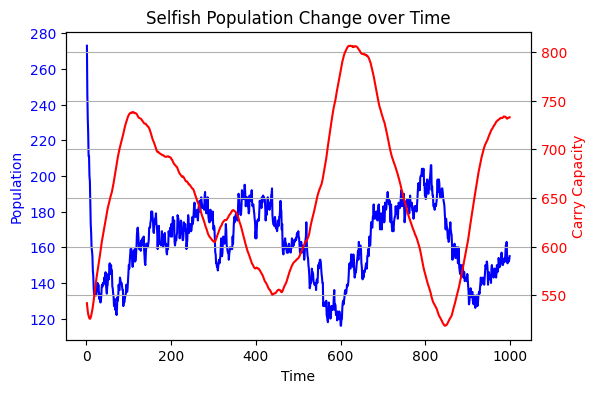

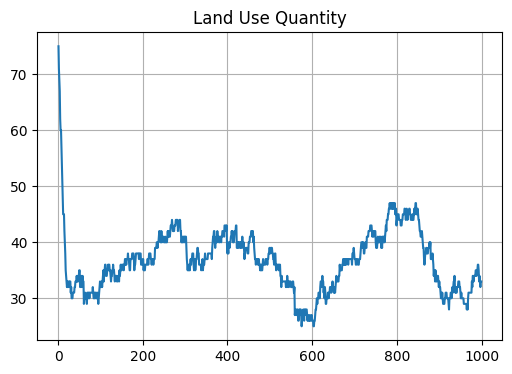

In [16]:
plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, 'different', 'split', 'cooperation')

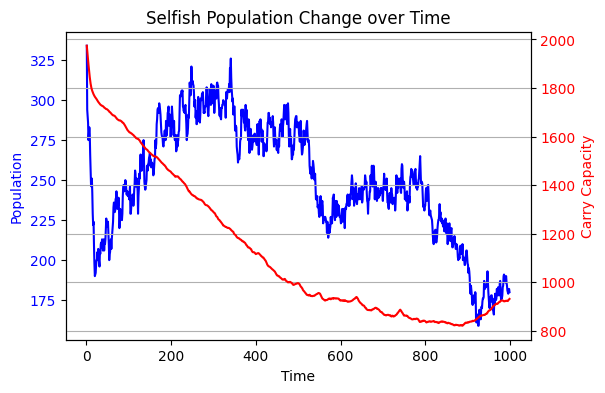

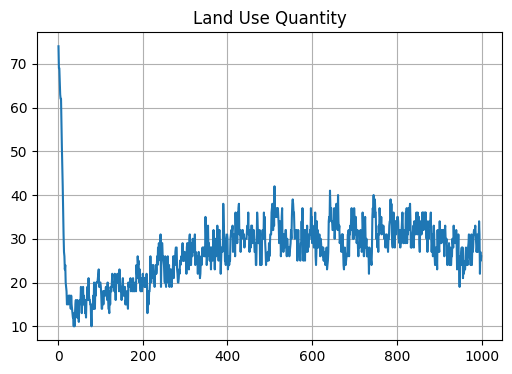

In [17]:
plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, 'unify', 'split', 'selfish')

In [10]:
populations, K, U, data, _ = communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, 'different', 'split', 'selfish')

# Define the dimension of the grid
grid_dim = int(np.sqrt(max(data[0].keys())))

# Create a colormap
cmap = plt.get_cmap('RdYlBu')

# Function to render the animation for a given year
def render_animation(year):
    # Get the data for the current year
    year_data = data.get(year, {})

    # Create an image with a white background
    image = Image.new('RGBA', (grid_dim * 100, grid_dim * 100), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(image)

    if year_data:
        # Iterate over each land cell for the current year
        for land_number, land_data in sorted(year_data.items()):
            usage = land_data.get('usage', 0)
            # Map the usage to a color
            color = (51, 102, 0) if usage == 1 else (255, 255, 255)

            # Calculate the position of the land cell
            x = (land_number % grid_dim) * 100
            y = (land_number // grid_dim) * 100

            # Draw a rectangle representing the land cell
            draw.rectangle([(x, y), (x + 100, y + 100)], fill=color)

    return image
# Create a list to store the animation frames
animation_frames = []

# Iterate over each year and generate frames
for year in range(max(data.keys()) + 1):
    image = render_animation(year)
    animation_frames.append(image)
    
animation_frames[0].save('usage_self_v2_village.gif', format='GIF', append_images=animation_frames[1:], save_all=True, duration=200, loop=0, optimize=True)
display(widgets.Image(value=open('usage_self_v2_village.gif', 'rb').read()))


Image(value=b'GIF89ax\x05x\x05\x87\x00\x00\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00…